#THE QUORA DATASET#

The Quora Insincere Questions Classification task revolves around identifying and categorizing inappropriate or insincere questions on the Quora platform. Quora, a popular Q&A website, hosts diverse discussions, but not all questions are genuine. Some may be disrespectful, offensive, or intended to provoke. The aim here is to create a machine learning model that can automatically label and distinguish such insincere questions

The dataset provided for this task comprises questions sourced from Quora, labeled as either "insincere" or "sincere." Insincere questions are those that exhibit characteristics of being disrespectful, offensive, or lacking genuine intent. On the other hand, sincere questions are those that are posed with the intention of seeking information or understanding.

This dataset includes text data representing the questions, alongside binary labels indicating whether each question is insincere or sincere. It follows the familiar pattern of supervised machine learning, where the objective is to train a model to discern patterns and features from the text that differentiate between sincere and insincere questions.

## 1. Importing Libraries

In [ ]:
!pip install --upgrade protobuf
!pip install -U "tensorflow-text==2.11.*"

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
%matplotlib inline

## 2. Data Ingestion

In [2]:
df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [4]:
df.tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


<Axes: title={'center': 'Target distribution'}, ylabel='Frequency'>

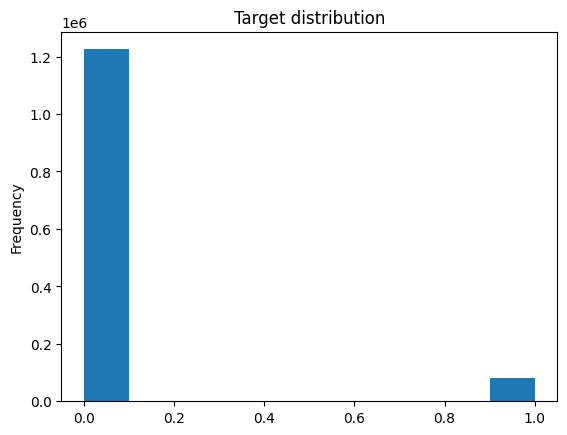

In [5]:
#analysin the distribution of the target variable

df.target.plot(kind='hist', title='Target distribution')

In [7]:
#lets see some insincere questions
df[df.target==1][:10].question_text.to_list()


['Has the United States become the largest dictatorship in the world?',
 'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
 "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
 'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
 'Which races have the smallest penis?',
 'Why do females find penises ugly?',
 'How do I marry an American woman for a Green Card? How much do they charge?',
 "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
 'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
 "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own laws?"]

In [8]:
#lets see some insincere questions
df[df.target==0][:10].question_text.to_list()

['How did Quebec nationalists see their province as a nation in the 1960s?',
 'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
 'Why does velocity affect time? Does velocity affect space geometry?',
 'How did Otto von Guericke used the Magdeburg hemispheres?',
 'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
 'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
 'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
 'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
 'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things chan

## 3. Splitting Data for train/test/validation

In [9]:
#Undersampling data

X = np.array(df.question_text).reshape(-1, 1)
y = np.array(df.target)

In [25]:
# RandomUnderSampler : Under-sample the majority class(es) by randomly
# picking samples with or without replacement
rus = RandomUnderSampler(random_state=0)

x_resampled, y_resampled = rus.fit_resample(X,y)

data  = {
    'question_text':np.squeeze(x_resampled),
    'target': y_resampled
}

X_resampled = pd.DataFrame(data)

X_resampled.shape

(161620, 2)

In [26]:
X_resampled.tail(20)

,question_text,target
161600,Do the Chinese people eat bath soap?,1
161601,Does this Congress have blood on their hands f...,1
161602,Why are men selective?,1
161603,Why do girls not prefer to become a physicist?,1
161604,Why do the people from Kannur in Kerala adjust...,1
161605,Why is there a trend for dresses to reveal the...,1
161606,Should I give my child a panic button or peppe...,1
161607,"Is it true that hydrogen is a light, odorless ...",1
161608,It is posible to kill 4months baby?,1
161609,Is it a fact that the Europeans are the bigges...,1


<Axes: title={'center': 'Target distribution'}, ylabel='Frequency'>

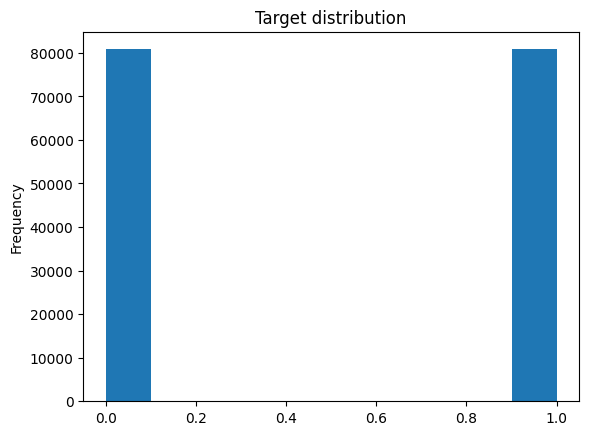

In [27]:
X_resampled.target.plot(kind='hist', title='Target distribution')

## 4. Cloning the BERT pretrained model from Tensorflow Hub

In [19]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [23]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

#Just we will choose some 2 examples to show the embedded output
get_sentence_embeding([
    "Who hires biomolecular engineer?",
    "Why do girls not prefer to become a physicist?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.93710816, -0.5718563 , -0.9825792 , ..., -0.9577722 ,
        -0.7495189 ,  0.9102026 ],
       [-0.8906666 , -0.4644663 , -0.8586575 , ..., -0.69950897,
        -0.734598  ,  0.9091555 ]], dtype=float32)>

## 5. Splitting the data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled['question_text'],X_resampled['target'])
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test)

In [29]:
print(f"Number of examples for training: {X_train.shape}")
print(f"Number of examples for testing: {X_test.shape}")
print(f"Number of examples for validation: {X_valid.shape}")

Number of examples for training: (121215,)
Number of examples for testing: (30303,)
Number of examples for validation: (10102,)


## 6. Creating the model

In [30]:
# BERT LAYERS
# input layer for text
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# this layer preprocess the data according to the bert especifications (lower cased text and stride accents)
preprocessed_text = bert_preprocess(text_input)
# bert encoding layer (Tensorflow-Hub)
outputs = bert_encoder(preprocessed_text)

# Dense Block for Clasification
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct the final model using inputs and outputs
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

## 7. Train the model

In [32]:
# Compile and especific the parameters to be trained
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size= 100)

Epoch 1/3
1213/1213 [==============================] - 1620s 1s/step - loss: 0.4976 - accuracy: 0.7696
Epoch 2/3
1213/1213 [==============================] - 1589s 1s/step - loss: 0.4218 - accuracy: 0.8152
Epoch 3/3
1213/1213 [==============================] - 1588s 1s/step - loss: 0.4049 - accuracy: 0.8240


<Figure size 640x480 with 0 Axes>

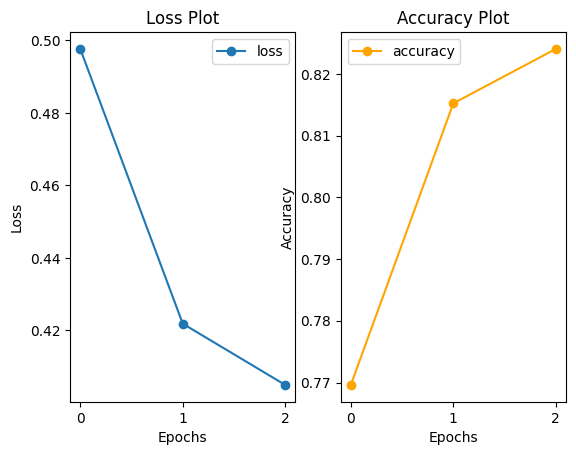

In [43]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(history.history['loss'])),history.history['loss'] , marker='o')
ax1.legend(['loss'])
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(len(history.history)+1))
ax1.set_ylabel('Loss')
ax1.set_title('Loss Plot', fontsize=12)

ax2.plot(range(len(history.history['accuracy'])),history.history['accuracy'] , marker='o', color='orange')
ax2.legend(['accuracy'])
ax2.set_xlabel('Epochs')
ax2.set_xticks(range(len(history.history)+1))
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Plot', fontsize=12)

plt.show()

# 8. Evaluate the model

In [44]:
print("X_test Dataset Evaluation")
result = model.evaluate(X_test, y_test)
dict(zip(model.metrics_names, result))

X_test Dataset Evaluation
947/947 [==============================] - 345s 363ms/step - loss: 0.3650 - accuracy: 0.8529


{'loss': 0.3649978041648865, 'accuracy': 0.8528528809547424}

In [45]:
print("X_valid Dataset Evaluation")
result = model.evaluate(X_valid, y_valid)
dict(zip(model.metrics_names, result))

X_valid Dataset Evaluation
316/316 [==============================] - 112s 355ms/step - loss: 0.3779 - accuracy: 0.8406


{'loss': 0.3778619170188904, 'accuracy': 0.8406256437301636}

In [49]:
print('Making Predictions on the Validation Dataset \n')
for question, prediction in zip(X_valid[:10], y_valid[:10]):
    prediction_label = 1 if prediction >= 0.5 else 0
    print(f"Question: {question}\n Target: {prediction} Prediction: {prediction_label}\n{'-' * 50}")

Making Predictions on the Validation Dataset 

Question: How does one handle the stress of founding a startup and having bipolar 2 disorder?
 Target: 0 Prediction: 0
--------------------------------------------------
Question: Why do Asians have so many scars compared to white people?
 Target: 1 Prediction: 1
--------------------------------------------------
Question: What are some ways to kill groundhogs?
 Target: 0 Prediction: 0
--------------------------------------------------
Question: Does one have to be connected to the internet in order to do word processing?
 Target: 0 Prediction: 0
--------------------------------------------------
Question: X is the name of an American rock band, a vaccine certificate issued by WHO and is used as part of a language-neutral system. What is X?
 Target: 0 Prediction: 0
--------------------------------------------------
Question: If you gave everyone in the United States, from Donald Trump to the penniless hobo, $1,000,000, then would anything 

In [ ]:
: